In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer
from transformers import Trainer, TrainingArguments

In [3]:
chat_data = pd.read_csv("/kaggle/input/breastcancerchat/BreastCancerChatbotDataset.csv")

In [4]:
chat_data.head()

,Questions,Answers,Patterns,Tags,Source
0,NaN,NaN,NaN,NaN,NaN
1,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
2,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
3,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
4,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...


In [5]:
# Removed NA
chat_data = chat_data.dropna()

In [7]:
chat_data.head()

,Questions,Answers,Patterns,Tags,Source
1,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
2,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
3,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
4,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...
5,What features of a palpable lump suggest breas...,If a palpable lump is found and possesses any ...,What is a lump. What characteristics of a palp...,lump palpable,https://www.medscape.com/answers/1947145-15524...



### <b>Extract Info from the dataframe</b>

In [8]:
chat_data_new = []
for index, row in chat_data.iterrows():
    # Split the pattern in each row using the "." character
    patterns = row['Patterns'].split('.')
    
    # Create a new row for each split pattern
    for pattern in patterns:
        # Strip leading/trailing whitespace from the pattern
        pattern = pattern.strip()
        
        # Skip empty patterns
        if pattern:
            new_row = {
                'Patterns': pattern,
                'Tags': row['Tags']
            }
            chat_data_new.append(new_row)

# Create a new DataFrame from the list of new rows
chat_patterns_intents = pd.DataFrame(chat_data_new)


In [9]:
chat_patterns_intents.head()

,Patterns,Tags
0,What precisely is breast cancer,breast cancer
1,Define breast cancer,breast cancer
2,Explain breast cancer,breast cancer
3,What is the definition of breast cancer,breast cancer
4,How would you describe breast cancer,breast cancer


In [10]:
df = chat_patterns_intents.copy()


### <b>Check the shape of the dataset</b>

In [11]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 646 rows and 2 columns



### <b>Display information about the dataset</b>

In [12]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Patterns  646 non-null    object
 1   Tags      646 non-null    object
dtypes: object(2)
memory usage: 10.2+ KB
None



### <b>Display Number of Classes</b>

In [13]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tags', "Chatbot")

The Chatbot dataset has 170 classes



### <b>Check the null values in the dataset</b>

In [14]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Patterns    0
Tags        0
dtype: int64



### <b> Visualize the Null Values</b>

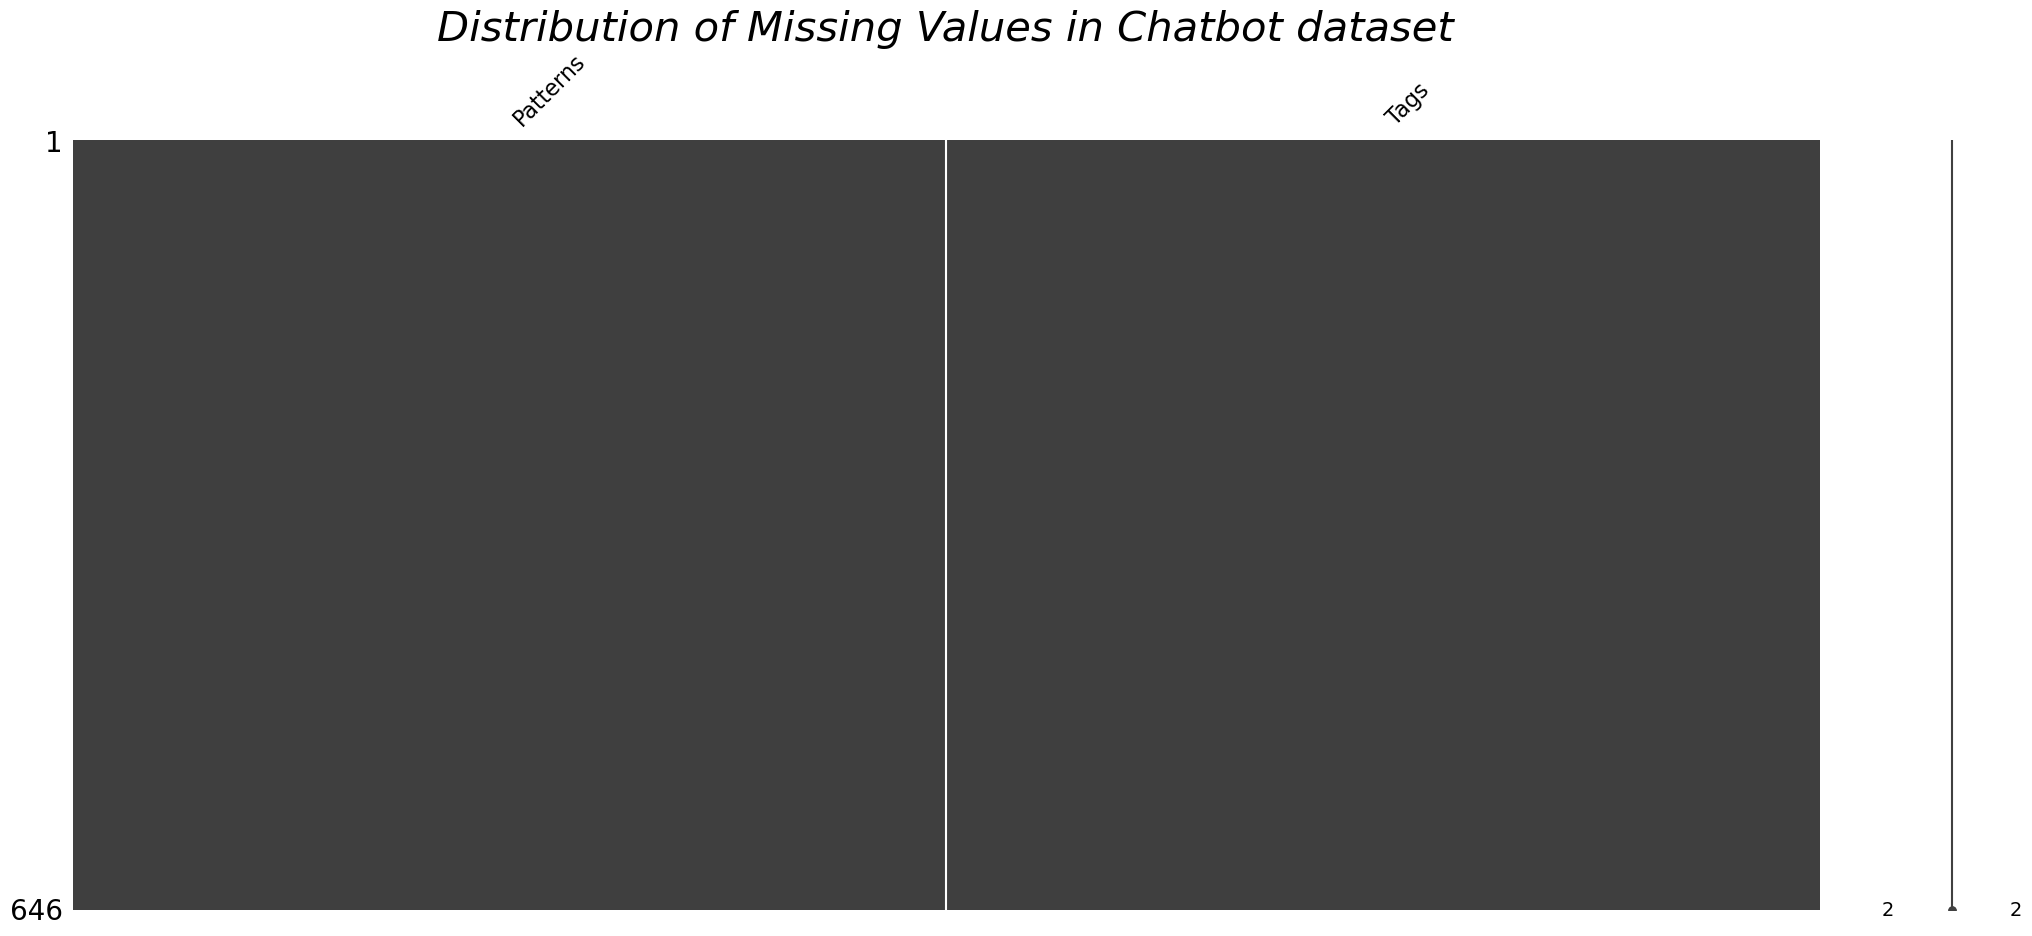

In [15]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()
    
plot_miss_vals(df, "Chatbot")


### <b> Visualize the distrbution of our Classes</b>

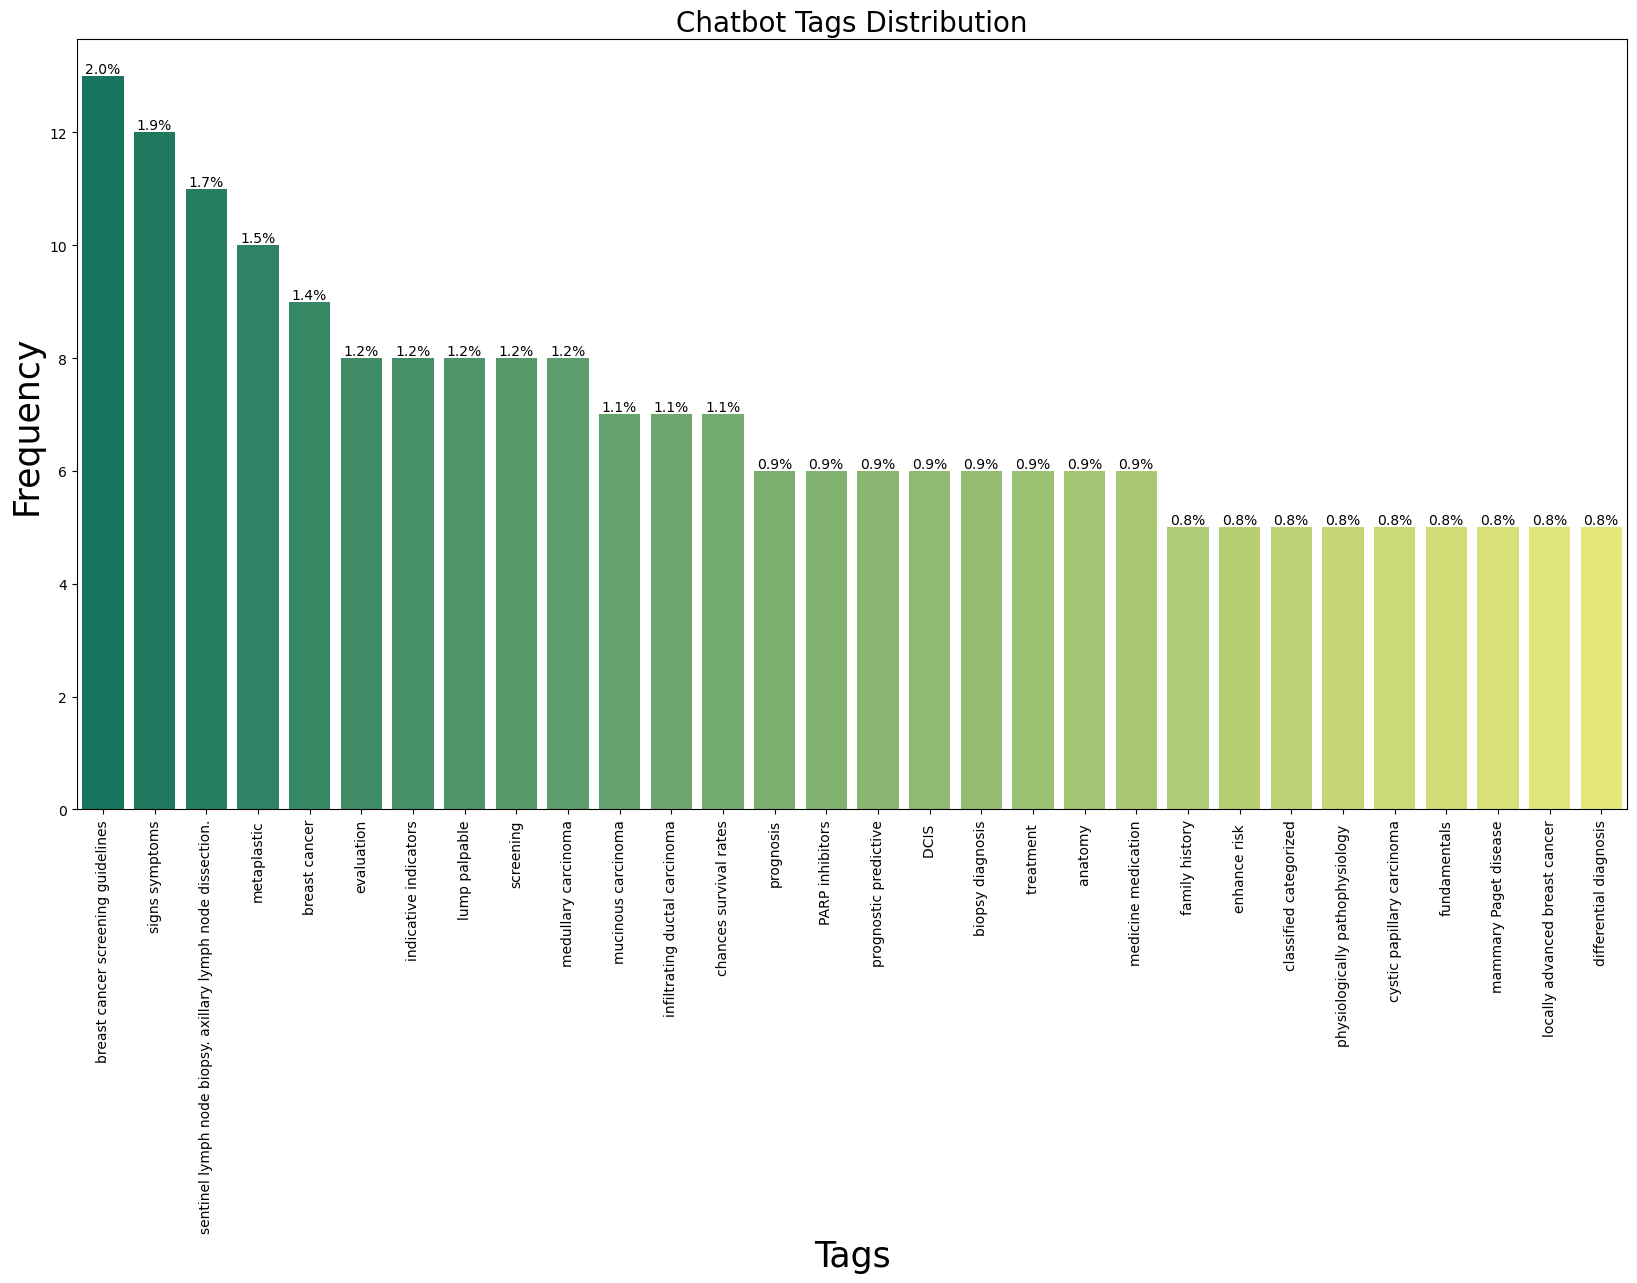

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def count_plot(x, df, title, xlabel, ylabel, width, height, order=None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width, height))
    ax = sns.countplot(x=x, data=df, palette=palette, order=order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation='vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y),
                    ha='center', va='bottom')  # set the alignment of the text

    plt.show()

# Get the top 30 classes
top_30_classes = df['Tags'].value_counts().index[:30]

# Call the count_plot function with the top 30 classes as order
count_plot(df['Tags'], df, "Chatbot Tags Distribution", "Tags", "Frequency", 20, 10, order=top_30_classes, rotation=True, palette="summer")


In [17]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  



In [41]:
df['Patterns'] = df['Patterns'].apply(preprocess_pattern)

In [18]:
df.head()

,Patterns,Tags
0,What precisely is breast cancer,breast cancer
1,Define breast cancer,breast cancer
2,Explain breast cancer,breast cancer
3,What is the definition of breast cancer,breast cancer
4,How would you describe breast cancer,breast cancer



### <b> Display Word Cloud</b>

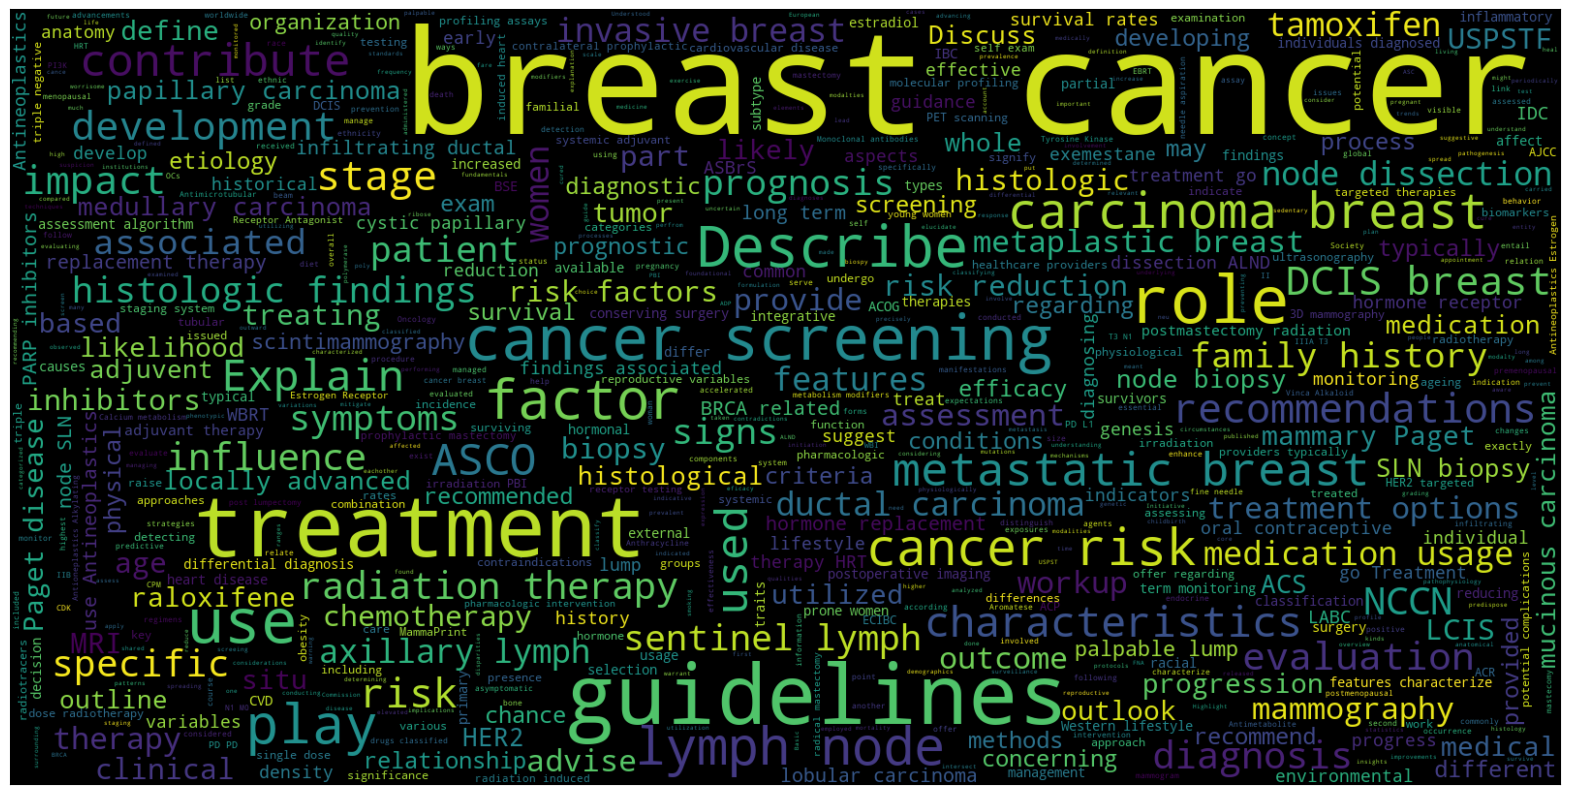

In [19]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=1500, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(chat_data['Patterns']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()


### <b> Distrbution of Number of letters in each text</b>

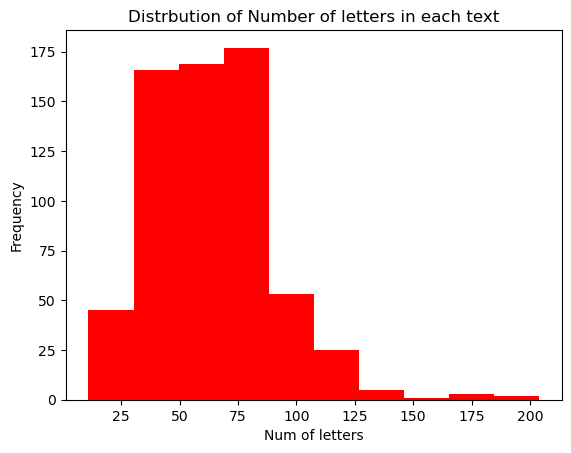

In [20]:
letters_len=df['Patterns'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()


### <b>Distrbution of Number of words in each text</b>

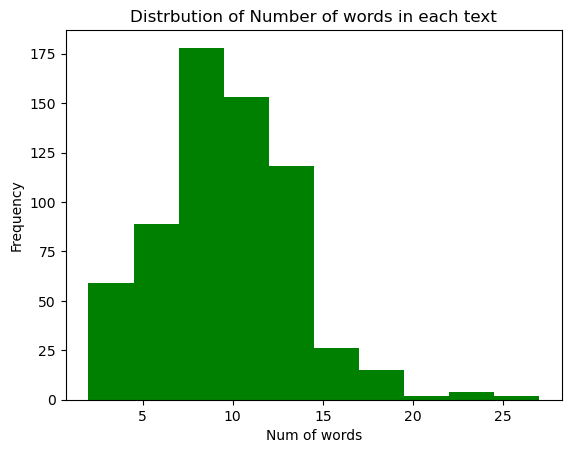

In [21]:
words_len=df['Patterns'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()


### <b>Visualize Average word length in each text</b>

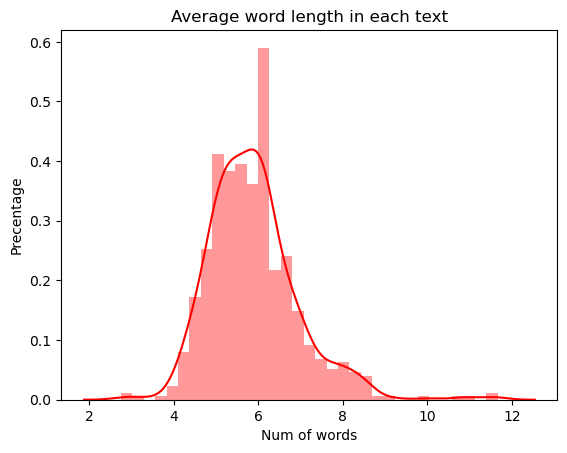

In [22]:
word=df['Patterns'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()


### <b>Visualize top words</b>

In [24]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Patterns)
corpus[:5]

['What', 'precisely', 'is', 'breast', 'cancer']

In [25]:
print(f"dataset contains {len(corpus)} words")

dataset contains 6141 words


In [26]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'breast': 546,
 'cancer': 516,
 'the': 312,
 'of': 295,
 'What': 198,
 'for': 172,
 'in': 171,
 'How': 109,
 'are': 101,
 'does': 98}

In [27]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

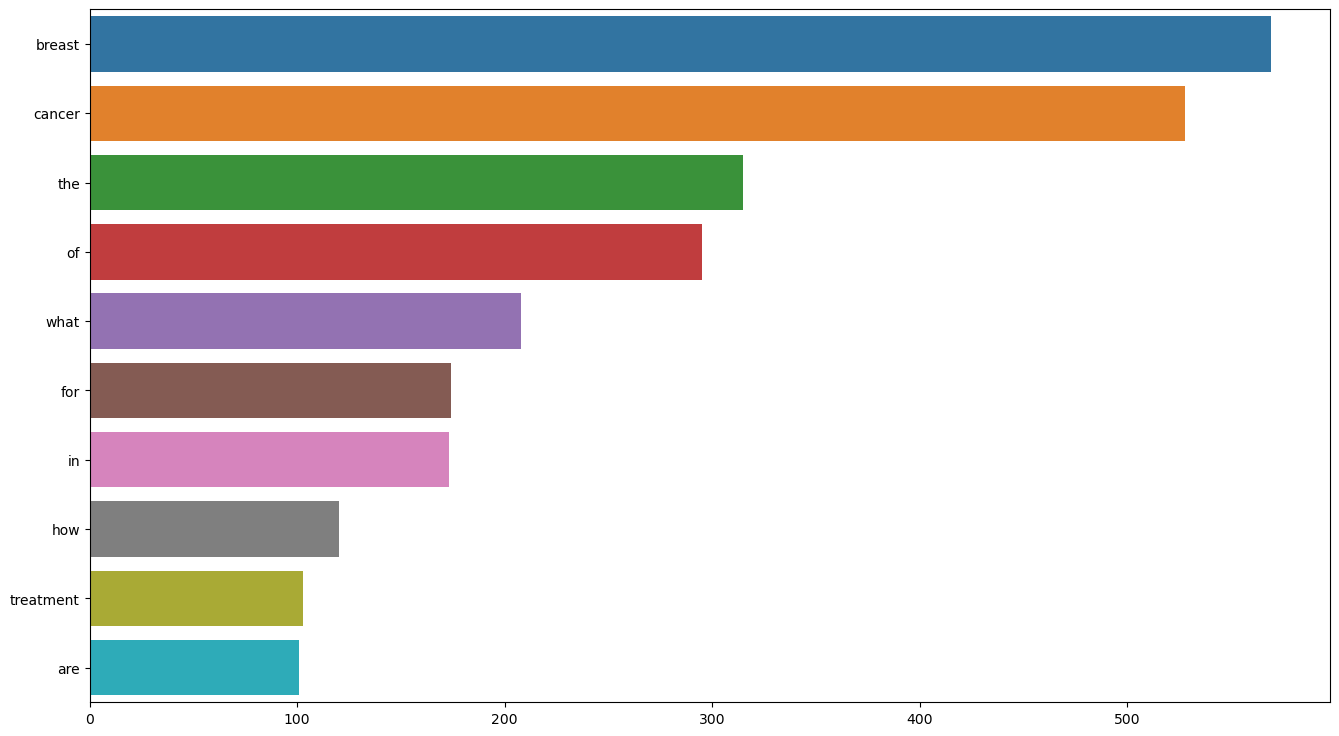

In [28]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Patterns,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));


## <b>Data Preprocessing</b>

In [29]:
df.head()

,Patterns,Tags
0,What precisely is breast cancer,breast cancer
1,Define breast cancer,breast cancer
2,Explain breast cancer,breast cancer
3,What is the definition of breast cancer,breast cancer
4,How would you describe breast cancer,breast cancer


In [30]:
labels = df['Tags'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['breast cancer',
 'signs symptoms',
 'evaluation',
 'indicative indicators',
 'lump palpable',
 'screening',
 'biopsy diagnosis',
 'treatment',
 'chemotherapy regimens',
 'medicine medication',
 'fundamentals',
 'anatomy',
 'physiologically pathophysiology',
 'classified categorized',
 'types found',
 'exactly develop causes',
 'ageing genesis age',
 'family history',
 'enhance risk',
 'history assessed',
 'reproductive',
 'estradiol',
 'oral contraceptives OCs',
 'hormone replacement therapy HRT',
 'cancer-prone HRT women',
 'menopausal',
 'historical factors',
 'lifestyle factors',
 'obesity etiology',
 'traits Western',
 'environmental factors',
 'common worldwide prevalence',
 'age incidence',
 'racial predilections phenotypic',
 'mortality rates',
 'prognosis',
 'prognostic predictive',
 'chances survival rates',
 'HER2-targeted therapies',
 'DCIS',
 'LCIS',
 'infiltrating ductal carcinoma',
 'medullary carcinoma',
 'mucinous carcinoma',
 'cystic papillary carcinoma',
 'metaplast

In [31]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [32]:
id2label

{0: 'breast cancer',
 1: 'signs symptoms',
 2: 'evaluation',
 3: 'indicative indicators',
 4: 'lump palpable',
 5: 'screening',
 6: 'biopsy diagnosis',
 7: 'treatment',
 8: 'chemotherapy regimens',
 9: 'medicine medication',
 10: 'fundamentals',
 11: 'anatomy',
 12: 'physiologically pathophysiology',
 13: 'classified categorized',
 14: 'types found',
 15: 'exactly develop causes',
 16: 'ageing genesis age',
 17: 'family history',
 18: 'enhance risk',
 19: 'history assessed',
 20: 'reproductive',
 21: 'estradiol',
 22: 'oral contraceptives OCs',
 23: 'hormone replacement therapy HRT',
 24: 'cancer-prone HRT women',
 25: 'menopausal',
 26: 'historical factors',
 27: 'lifestyle factors',
 28: 'obesity etiology',
 29: 'traits Western',
 30: 'environmental factors',
 31: 'common worldwide prevalence',
 32: 'age incidence',
 33: 'racial predilections phenotypic',
 34: 'mortality rates',
 35: 'prognosis',
 36: 'prognostic predictive',
 37: 'chances survival rates',
 38: 'HER2-targeted therapi

In [33]:
label2id

{'breast cancer': 0,
 'signs symptoms': 1,
 'evaluation': 2,
 'indicative indicators': 3,
 'lump palpable': 4,
 'screening': 5,
 'biopsy diagnosis': 6,
 'treatment': 7,
 'chemotherapy regimens': 8,
 'medicine medication': 9,
 'fundamentals': 10,
 'anatomy': 11,
 'physiologically pathophysiology': 12,
 'classified categorized': 13,
 'types found': 14,
 'exactly develop causes': 15,
 'ageing genesis age': 16,
 'family history': 17,
 'enhance risk': 18,
 'history assessed': 19,
 'reproductive': 20,
 'estradiol': 21,
 'oral contraceptives OCs': 22,
 'hormone replacement therapy HRT': 23,
 'cancer-prone HRT women': 24,
 'menopausal': 25,
 'historical factors': 26,
 'lifestyle factors': 27,
 'obesity etiology': 28,
 'traits Western': 29,
 'environmental factors': 30,
 'common worldwide prevalence': 31,
 'age incidence': 32,
 'racial predilections phenotypic': 33,
 'mortality rates': 34,
 'prognosis': 35,
 'prognostic predictive': 36,
 'chances survival rates': 37,
 'HER2-targeted therapies':

In [37]:
df['labels'] = df['Tags'].map(lambda x: label2id[x.strip()])
df.head()

,Patterns,Tags,labels
0,What precisely is breast cancer,breast cancer,0
1,Define breast cancer,breast cancer,0
2,Explain breast cancer,breast cancer,0
3,What is the definition of breast cancer,breast cancer,0
4,How would you describe breast cancer,breast cancer,0



## <b>Split the data into train and test</b>

In [38]:
X = list(df['Patterns'])
X[:5]

['What precisely is breast cancer',
 'Define breast cancer',
 'Explain breast cancer',
 'What is the definition of breast cancer',
 'How would you describe breast cancer']

In [39]:
y = list(df['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)


## <b>Loading models and Tokenizer</b>

In [64]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [41]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Define your model_name, max_len, num_labels, id2label, and label2id
model_name = "distilbert-base-uncased"
max_len = 256

# Load tokenizer and model
distillbert_tokenizer = DistilBertTokenizer.from_pretrained(model_name, max_length=max_len)
distillbert_model = DistilBertForSequenceClassification.from_pretrained(model_name, 
                                                              num_labels=num_labels, 
                                                              id2label=id2label, 
                                                              label2id=label2id)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.


## <b>Transform the data into numerical format</b>

In [69]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [42]:
train_encoding_distillbert = distillbert_tokenizer(X_train, truncation=True, padding=True)
test_encoding_distillbert = distillbert_tokenizer(X_test, truncation=True, padding=True)

In [68]:
full_data = tokenizer(X, truncation=True, padding=True)

In [43]:
full_data_distillbert = distillbert_tokenizer(X, truncation=True, padding=True)


## <b> Build Data Loader</b>


In [44]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [70]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [45]:
train_dataloader_distillbert = DataLoader(train_encoding_distillbert, y_train)
test_dataloader_distillbert = DataLoader(test_encoding_distillbert, y_test)

In [71]:
fullDataLoader = DataLoader(full_data, y_test)

In [46]:
fullDataLoader_distillbert = DataLoader(full_data_distillbert, y_test)


## <b>Define Evaluation Metrcies</b>


In [47]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## <b>Define Training Arguments</b>


In [72]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=200,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)


## <b>Train the model</b>


In [73]:
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

In [49]:
trainer_distillbert = Trainer(
    model=distillbert_model,
    args=training_args,                 
    train_dataset=train_dataloader_distillbert,         
    eval_dataset=test_dataloader_distillbert,            
    compute_metrics= compute_metrics
)

In [50]:
trainer_distillbert.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,5.109600,5.068037,0.043210,0.003819,0.002128,0.027928
100,4.634500,4.598188,0.228395,0.129974,0.123171,0.198333
150,3.528200,3.866693,0.351852,0.247950,0.234356,0.313525
200,2.340000,3.214997,0.444444,0.331104,0.333121,0.378968
250,1.427900,2.673333,0.530864,0.431848,0.440038,0.469733
300,0.802600,2.185537,0.629630,0.530857,0.528114,0.564400
350,0.418700,1.835596,0.679012,0.607713,0.612652,0.633058
400,0.211900,1.599019,0.709877,0.625278,0.621230,0.656667
450,0.110000,1.493300,0.722222,0.661823,0.658527,0.693162
500,0.071400,1.439417,0.728395,0.664689,0.665234,0.695763


TrainOutput(global_step=1600, training_loss=0.5952174879796803, metrics={'train_runtime': 378.9219, 'train_samples_per_second': 255.462, 'train_steps_per_second': 4.223, 'total_flos': 1004786090880000.0, 'train_loss': 0.5952174879796803, 'epoch': 200.0})

In [73]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,5.099900,5.091736,0.006173,0.004202,0.002801,0.008403
100,4.646000,4.756330,0.104938,0.067881,0.070388,0.082667
150,3.764800,4.171705,0.246914,0.144973,0.153680,0.188172
200,2.811200,3.587127,0.364198,0.251383,0.246325,0.295276
250,1.996500,3.126240,0.432099,0.328024,0.316798,0.366142
300,1.358200,2.679870,0.475309,0.374099,0.368635,0.415748
350,0.878500,2.346202,0.555556,0.465247,0.457333,0.504667
400,0.558000,2.101563,0.592593,0.533095,0.526528,0.567778
450,0.338500,1.890253,0.598765,0.530933,0.529404,0.566125
500,0.208400,1.783170,0.617284,0.559399,0.558402,0.596556


TrainOutput(global_step=1600, training_loss=0.7051197961717844, metrics={'train_runtime': 724.24, 'train_samples_per_second': 133.657, 'train_steps_per_second': 2.209, 'total_flos': 2540792899497600.0, 'train_loss': 0.7051197961717844, 'epoch': 200.0})


## <b>Evaluate the model</b>


In [74]:
q=[trainer.evaluate(eval_dataset=chat_data_new) for chat_data_new in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.020646,1.000000,1.000000,1.000000,1.000000
test,1.642134,0.648148,0.592579,0.601667,0.619861


In [53]:
q=[trainer_distillbert.evaluate(eval_dataset=chat_data_new) for chat_data_new in [train_dataloader_distillbert, test_dataloader_distillbert]]
 
pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.007027,1.000000,1.000000,1.000000,1.00000
test,1.389598,0.716049,0.648179,0.647039,0.67451


In [75]:
def predict(text):
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [55]:
def predict_distillbert(text):
    
    inputs = distillbert_tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = distillbert_model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = distillbert_model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [56]:
text = "What are the symptoms of breast cancer"
predict_distillbert(text)

(tensor([[1.7323e-06, 9.9717e-01, 1.5338e-05, 1.6507e-04, 4.9991e-05, 1.1606e-05,
          4.0814e-06, 5.0723e-05, 5.0345e-06, 7.0508e-06, 7.1802e-06, 2.9204e-05,
          8.3885e-06, 6.6746e-06, 7.4851e-05, 6.5264e-05, 7.6755e-06, 1.4281e-05,
          3.4669e-05, 4.7116e-06, 2.3464e-05, 2.3278e-06, 1.3207e-05, 2.2902e-06,
          9.1230e-07, 2.7232e-05, 9.6425e-06, 4.7302e-06, 3.1935e-06, 3.2546e-05,
          6.6345e-05, 1.6871e-05, 1.2873e-04, 1.3512e-04, 4.1161e-05, 1.2910e-04,
          6.9838e-06, 3.5093e-05, 1.7407e-06, 1.1418e-05, 3.1722e-06, 1.6433e-05,
          1.5848e-06, 4.5869e-05, 9.5173e-06, 2.5217e-05, 8.3090e-05, 4.3722e-06,
          7.3077e-05, 1.7304e-05, 2.1856e-05, 9.9123e-05, 2.5773e-04, 4.2745e-05,
          1.2237e-06, 2.4835e-05, 1.0292e-05, 2.7297e-06, 4.9145e-06, 5.1816e-06,
          5.4098e-06, 1.2382e-05, 4.9661e-06, 2.6083e-06, 4.2682e-06, 3.1987e-06,
          4.0861e-06, 8.0370e-06, 4.6996e-06, 6.5618e-06, 4.9233e-06, 9.3204e-06,
          2.2387

In [ ]:
text = "What are the symptoms of breast cancer"
predict(text)

In [74]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Define your model_name, max_len, num_labels, id2label, and label2id
model_name = "google/electra-base-discriminator"  # or any other Electra model
max_len = 256



# Load tokenizer and model
tokenizer = ElectraTokenizer.from_pretrained(model_name, max_length=max_len)
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)




trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

# Train the model
trainer.train()




Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,5.116100,5.101843,0.055556,0.010092,0.006799,0.032759
100,4.905600,4.894758,0.092593,0.037482,0.034086,0.077876
150,4.366900,4.454282,0.185185,0.097229,0.088489,0.154783
200,3.616400,3.954180,0.259259,0.174242,0.169628,0.230769
250,2.840400,3.497139,0.327160,0.216303,0.204415,0.283470
300,2.141500,3.089285,0.388889,0.276507,0.261601,0.330469
350,1.533300,2.727579,0.487654,0.382161,0.379706,0.417708
400,1.049800,2.415519,0.537037,0.445570,0.452344,0.473177
450,0.687700,2.164274,0.574074,0.494252,0.495238,0.528307
500,0.437200,1.964477,0.611111,0.529638,0.527581,0.568533


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27 trainer.train()                                                                             │
│   28                                                                                             │
│   29 # Evaluate the model                                                                        │
│ ❱ 30 eval_results = trainer.evaluate(eval_dataset=val_dataset)                                   │
│   31 print("Evaluation results:", eval_results)                                                  │
│   32                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'val_dataset' is not defined

In [88]:
q=[trainer.evaluate(eval_dataset=chat_data_new) for chat_data_new in [train_dataloader, test_dataloader]]
 
pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.011053,1.000000,1.000000,1.00000,1.000000
test,1.650910,0.679012,0.596348,0.60336,0.628226



## <b>Save the model</b>


In [78]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [57]:
model_path = "chatbot_distillbert"
trainer_distillbert.save_model(model_path)
distillbert_tokenizer.save_pretrained(model_path)

('chatbot_distillbert/tokenizer_config.json',
 'chatbot_distillbert/special_tokens_map.json',
 'chatbot_distillbert/vocab.txt',
 'chatbot_distillbert/added_tokens.json')


## <b>Load the model</b>


In [79]:
model_path = "/kaggle/working/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [82]:
from transformers import DistilBertForSequenceClassification,DistilBertTokenizerFast

model_path = "/kaggle/working/chatbot_distillbert"


model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer= DistilBertTokenizerFast.from_pretrained(model_path)
distill_chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [83]:
distill_chatbot("What is breast cancer ?")

[{'label': 'breast cancer', 'score': 0.9651627540588379}]

In [84]:
import pickle

# Serialize model and tokenizer
model_tokenizer_dict = {
    'model': model,
    'tokenizer': tokenizer
}


pickle_file_path = '/kaggle/working/chatbot.pkl'


with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(model_tokenizer_dict, pickle_file)

In [85]:
# Load the pickle file
with open(pickle_file_path, 'rb') as pickle_file:
    loaded_model_tokenizer_dict = pickle.load(pickle_file)

# Retrieve the model and tokenizer
loaded_model = loaded_model_tokenizer_dict['model']
loaded_tokenizer = loaded_model_tokenizer_dict['tokenizer']

# You can then use the loaded model and tokenizer as needed
chatbot = pipeline("sentiment-analysis", model=loaded_model, tokenizer=loaded_tokenizer)

In [86]:
chatbot("What is breast cancer ?")

[{'label': 'breast cancer', 'score': 0.9651627540588379}]

In [60]:
import pickle

# Serialize model and tokenizer
model_tokenizer_dict = {
    'model': model,
    'tokenizer': tokenizer
}

# Specify the path for saving the pickle file
pickle_file_path = '/kaggle/working/chatbot_model_distill.pkl'

# Save the dictionary containing model and tokenizer to a pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(model_tokenizer_dict, pickle_file)


In [76]:
# Load the pickle file
with open(pickle_file_path, 'rb') as pickle_file:
    loaded_model_tokenizer_dict = pickle.load(pickle_file)

# Retrieve the model and tokenizer
loaded_model = loaded_model_tokenizer_dict['model']
loaded_tokenizer = loaded_model_tokenizer_dict['tokenizer']

# You can then use the loaded model and tokenizer as needed
chatbot = pipeline("sentiment-analysis", model=loaded_model, tokenizer=loaded_tokenizer)

In [78]:
chatbot("What is breast cancer ?")

[{'label': 'breast cancer', 'score': 0.9651627540588379}]